# Tutorial Notebook for nisarhdf.nisarGCOVHDF
---

In [4]:
import os
env_proj = '/home/ubuntu/micromamba/envs/nisarhdf_py311/share/proj'
os.environ['PROJ_LIB'] = env_proj
# Inform pyproj about the dir too
from pyproj import datadir
datadir.set_data_dir(env_proj)
print('PROJ_LIB set to', os.environ['PROJ_LIB'])
print('pyproj datadir:', datadir.get_data_dir())
from osgeo import gdal
print('GDAL version:', gdal.__version__)
print('sample files in PROJ dir:', sorted(os.listdir(env_proj))[:10])

PROJ_LIB set to /home/ubuntu/micromamba/envs/nisarhdf_py311/share/proj
pyproj datadir: /home/ubuntu/micromamba/envs/nisarhdf_py311/share/proj
GDAL version: 3.11.4
sample files in PROJ dir: ['CH', 'GL27', 'ITRF2000', 'ITRF2008', 'ITRF2014', 'ITRF2020', 'deformation_model.schema.json', 'nad.lst', 'nad27', 'nad83']


This notebook demonstrates the functionality of `nisarGCOVHDF`, which is at tool for reading NISAR **GCOV** products.  Some of its functionality is specifically developed for the Greenland Mapping Project (GrIMP) workflows, but it may also be of general use for working with these products. If nothing else, the source code provides examples of how to unpack these projects.

## Installation

This notebook has been tested in the NISAR on-demand-system base environment. It can be installed with:

`pip install git+https://github.com/fastice/nisarhdf.git@main`

In other environments, the easiest way to ensure the code works is to create a custom environment using the *environment.yml* file included in this *nisarhdf* repository. To do so execute the following,

`conda env create -f environment.yml`

Then setup the kernel for the Jupyter notebooks with the command:

`python -m ipykernel install --user --name=nisarcryo`

Then activate the environment:

`conda activate nisarcryo`

Finally, start Jupyter and open the notebooks.

**Even if you want to work with your existing environment, the *environment.yml* file demonstrates which packages must be installed if they are not already present.**


## Python Imports

In [5]:
%load_ext autoreload
%autoreload 2
import os
import nisarhdf
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import rioxarray
from osgeo import gdal
import os
import getpass
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
if not os.path.exists('./output'):
    os.mkdir('./output')

## Open the HDF

Access files via:

- **`s3`** – ODS links (e.g., `s3://nisar-public/...`)
- **`https`** – NISAR sample product suite via ASF (e.g., redirect to signed S3 URL)
- **`local`** – Specify a local path to the HDF5 file.

Create an instance and open the hdf as shown below. For normal products, you shouldn't have to specify the orbit, but while the orbit fields are present in the example file, they are not populated. When you open the hdf, you can specify the precise orbit XMLs if desired, which are release a few weeks after the MOI orbits used in the processing.

In [7]:
files = {'local': '/dev/shm/oasis/NISAR_L2_PR_GCOV_005_118_D_009_2005_DHDH_A_20250924T124314_20250924T124348_S00408_P_P_J_001.h5'} # Modify to local file path

In [8]:
GCOVFile  = files['local']
GCOVFile

'/dev/shm/oasis/NISAR_L2_PR_GCOV_005_118_D_009_2005_DHDH_A_20250924T124314_20250924T124348_S00408_P_P_J_001.h5'

In [9]:
%%time
myGCOV = nisarhdf.nisarGCOVHDF()
myGCOV.openHDF(GCOVFile, referenceOrbitXML=None, referenceOrbit=0)

CPU times: user 3.99 s, sys: 565 ms, total: 4.55 s
Wall time: 4.56 s


## GCOV Parameters

A summary of some of the more important parameters for the **GCOV** products can be obtained by.

In [8]:
myGCOV.printParams()


Select Parameters
GCOV.track = 118 
GCOV.referenceOrbit = 0 
GCOV.frame = 9 
GCOV.datetime = 2025-09-24 12:43:14 
GCOV.centerLat = 88.67992254758859 
GCOV.centerLon = 22.72274355271843 
GCOV.referenceGranule = NISAR_L1_PR_RSLC_005_118_D_009_2005_DHDH_A_20250924T124314_20250924T124348_A00408_P_P_J_001.h5 
GCOV.rangeBandwidth = 20000000.0 
GCOV.SLCNearRange = 884412.7338048334 
GCOV.SLCFarRange = 1051490.8180539585 
GCOV.SLCFirstZeroDopplerTime = 45794.0 
GCOV.SLCLastZeroDopplerTime = 45828.999342105264 
GCOV.LookDirection = left 
GCOV.PassType = descending 
GCOV.Wavelength = 0.24393202441008952 
GCOV.PRF = 1520.0 
GCOV.epsg = 4326 
GCOV.xSize = 11086 
GCOV.ySize = 9662 
GCOV.NumberRangeLooks = Variable 
GCOV.NumberAzimuthLooks = Variable 

Data Fields
GCOV.HHHH
GCOV.HVHV
GCOV.mask
GCOV.numberOfLooks
GCOV.rtcGammaToSigmaFactor


## Display Data

The following plots the fields associated with the **GCOV** product.

HHHH
HVHV
mask
numberOfLooks
rtcGammaToSigmaFactor


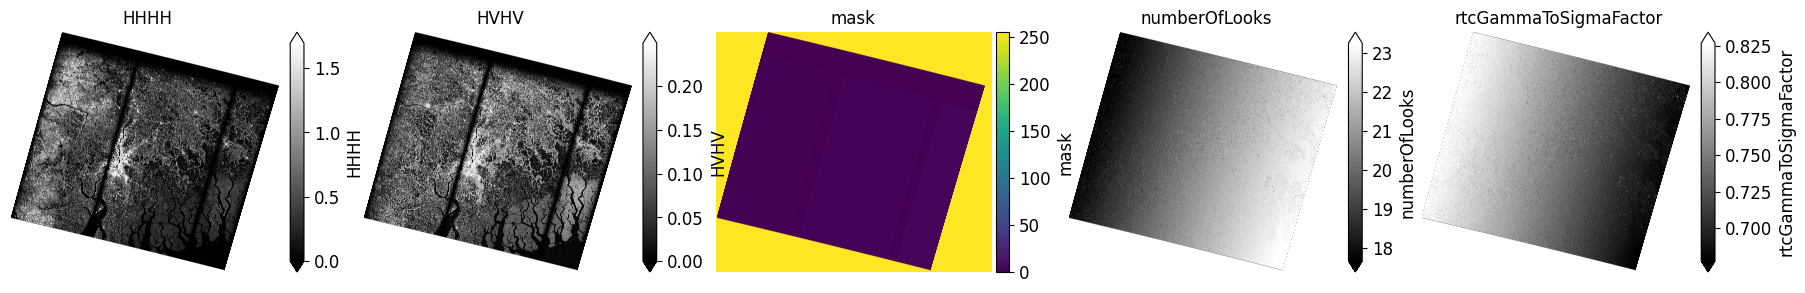

In [9]:
fields = myGCOV.dataFields
fig, axes = plt.subplots(1, len(fields), figsize=(22, 4))
for field, ax in zip(fields, axes.flatten()):
    data = getattr(myGCOV, field)
    print(field)
    vmin, vmax = nisarhdf.autoScaleRange(data, 95)
    if field not in ['mask']:
        h = ax.imshow(data, vmin=vmin, vmax=vmax, origin='upper', cmap='gray')
        nisarhdf.colorBar(h, ax, field, 'right', '5%',.05, 12, 12, extend='both')
    else:
        h = ax.imshow(data,  origin='upper')
        nisarhdf.colorBar(h, ax, field,'right', '5%',.05, 12, 12, extend='neither')
    ax.set_title(field)
    ax.axis('off')

## Metadata Interpolation

Much of the spatially dependent information (e.g., incidenceAngle) is stored as metadata cubes (see nisar documenation). These cubes can be interpolatated to obtain the x, y, and elevation dependent results. Here are examples of how to extract these data for the offset grids.

For each field, there is an interpolator method (e.g., `myGCOV.incidenceAngleCube(x, y, z)`). The examples below demonstrate how to interpolate the data cubes to the coordinates of the GCOV product.

### Setup Grid for the Offsets

In this step a range/Dopper grid corresponding to the offset maps is created. Note in this example we assume zero elevation, but the values can easily be substituted from a DEM.

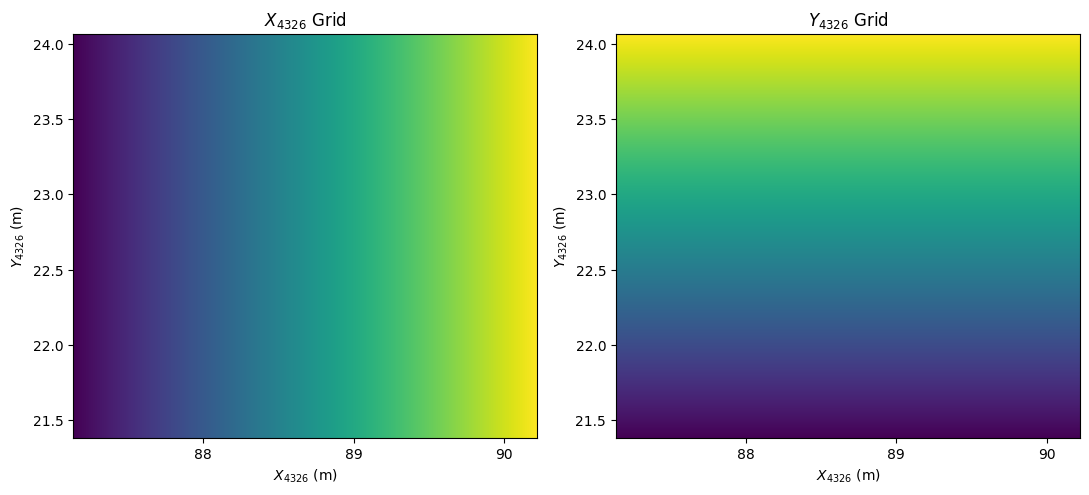

In [10]:
myGCOV.setupXYGrid()
z = np.zeros(myGCOV.xGrid.shape)
fig, axes = plt.subplots(1, 2, figsize=(11, 5))
axes[0].imshow(myGCOV.xGrid, extent=myGCOV.extentUL)
axes[1].imshow(myGCOV.yGrid, extent=myGCOV.extentUL)
for ax, field in zip(axes, [f'$X_{{{myGCOV.epsg}}}$ Grid',f'$Y_{{{myGCOV.epsg}}}$ Grid']):
    ax.set_title(field)
    ax.locator_params(axis='x', nbins=4)
    ax.set_title(field)
    ax.set_xlabel(f'$X_{{{myGCOV.epsg}}}$ (m)')
    ax.set_ylabel(f'$Y_{{{myGCOV.epsg}}}$ (m)')
fig.tight_layout()

### Incidence and Elevation Angles

The incidence and elevation angles can be computed as follows:

incidenceAngle min/max: 29.956 50.521
elevationAngle min/max: 26.527 43.660
CPU times: user 2min 40s, sys: 42.1 s, total: 3min 22s
Wall time: 3min 22s


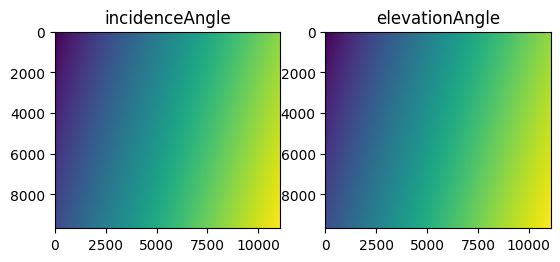

In [11]:
%%time
incidenceAngle = myGCOV.incidenceAngleCube(myGCOV.xGrid, myGCOV.yGrid, z, maskNoData=myGCOV.noDataLocations)
elevationAngle = myGCOV.elevationAngleCube(myGCOV.xGrid, myGCOV.yGrid, z, maskNoData=myGCOV.noDataLocations)
fig, axes = plt.subplots(1, 2)
for ax, var, title in zip(axes.flatten(), [incidenceAngle, elevationAngle], ['incidenceAngle', 'elevationAngle']):
    ax.imshow(var, origin='upper')
    ax.set_title(title)
    print(f'{title} min/max: {np.nanmin(var):.3f} {np.nanmax(var):.3f}')

### Ground Track Velocity

The ground track velocity is found by:

groundTrackVelocity min/max: 6766.119 6782.007


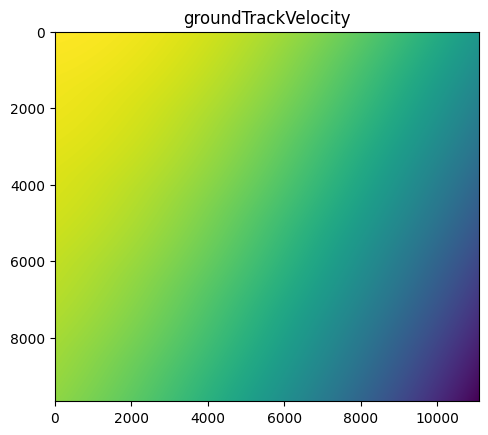

In [12]:
groundTrackVelocity=  myGCOV.groundTrackVelocityCube(myGCOV.xGrid, myGCOV.yGrid, z, maskNoData=myGCOV.noDataLocations)
fig, ax = plt.subplots(1,1)
ax.imshow(groundTrackVelocity, origin='upper')
ax.set_title('groundTrackVelocity')
print(f'groundTrackVelocity min/max: {np.nanmin(groundTrackVelocity):.3f} {np.nanmax(groundTrackVelocity):.3f}')

### Range-Doppler Coordinate

The `slantRange` and `zeroDopplerTime` coordinate at corresponding to the `x` and `y` can can be determined as:

slantRange min/max: 854245.599 1103574.077
zeroDopplerTime min/max: 45784.241 45838.614


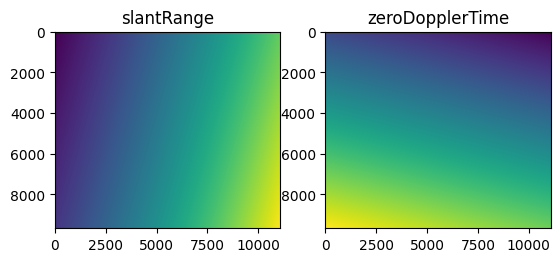

In [13]:
slantRange, zeroDopplerTime =  myGCOV.rangeDopplerCube(myGCOV.xGrid, myGCOV.yGrid, z, image='reference', maskNoData=myGCOV.noDataLocations)
fig, axes = plt.subplots(1, 2)
for ax, var, title in zip(axes.flatten(), [slantRange, zeroDopplerTime], ['slantRange', 'zeroDopplerTime']):
    ax.imshow(var, origin='upper')
    ax.set_title(title)
    print(f'{title} min/max: {np.nanmin(var):.3f} {np.nanmax(var):.3f}')

### Along Track Unit Vector and LOS Unit Vector

The x and y components of the line-of-sight and along-track unit vector can be determined on the offset grid by:

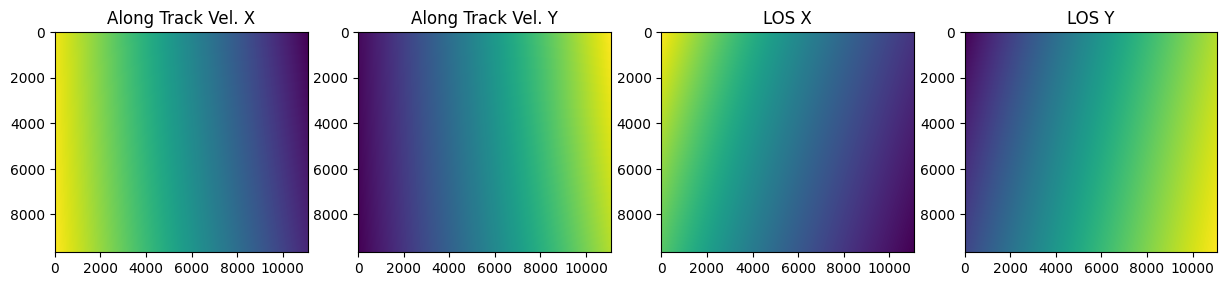

In [14]:
ATx, ATy =  myGCOV.alongTrackUnitVectorCube(myGCOV.xGrid, myGCOV.yGrid, z, maskNoData=myGCOV.noDataLocations)
LOSx, LOSy=  myGCOV.losUnitVectorCube(myGCOV.xGrid, myGCOV.yGrid, z, maskNoData=myGCOV.noDataLocations)
#
fig, axes = plt.subplots(1, 4, figsize=(15,5))
for ax, var, title in zip(axes.flatten(), [ATx, ATy, LOSx, LOSy], ['Along Track Vel. X', 'Along Track Vel. Y', 'LOS X', 'LOS Y']):
    ax.imshow(var, origin='upper')
    ax.set_title(title)

## Other Meta Data

Most of the essential meta data has been parsed and demonstrated in the examples above. Other quantities can be extracted by keyword from the h5 files. For example, the **centerFrequency** can be extracted as:

In [ ]:
np.array(myGCOV.h5['GCOV']['grids']['frequencyA']['projection']).item()

32611

## Save Data to Binary or Tiff Files.

The data from the hdf can be save as individual tiffs, bound together by a single vrt file. The default is to write all of the bands e.,g `'VVVV'`, `'mask'`, `'numberOfLooks'`, and `'rtcGammaToSigmaFactor'` for a **GCOV** product, which is accomplished as follows.

In [16]:
from pyproj import datadir
print('pyproj datadir ->', datadir.get_data_dir())
import os
print('PROJ_LIB:', os.environ.get('PROJ_LIB'))
from osgeo import gdal
print('GDAL library version:', gdal.__version__)

pyproj datadir -> /home/ubuntu/micromamba/envs/nisarhdf_py311/lib/python3.11/site-packages/pyproj/proj_dir/share/proj
PROJ_LIB: None
GDAL library version: 3.11.4


In the previous example, the results were save as tiffs. To save as binary files, run with `tiff=False` for a more limited set of bands:

In [11]:
myGCOV.writeData('/dev/shm/oasis', bands=[myGCOV.dataFields[0], 'rtcGammaToSigmaFactor'], tiff=True)
!ls /dev/shm/oasis

AGENTS.md
NISAR_L2_PR_GCOV_005_118_D_009_2005_DHDH_A_20250924T124314_20250924T124348_S00408_P_P_J_001.h5
NISAR_L2_PR_GCOV_006_069_D_068_4005_DHDH_M_20251009T235223_20251009T235259_P00410_N_F_J_001.h5
NISAR_L2_PR_GCOV_006_081_D_009_4005_DHDH_A_20251003T231520_20251003T231554_S00408_P_P_J_001.h5
NISAR_L2_PR_GCOV_006_088_A_006_2005_QPDH_A_20251004T101444_20251004T101518_S00408_P_P_J_001.h5
NISAR_L2_PR_GCOV_007_102_D_057_4005_DHDH_A_20251012T064215_20251012T064249_P00410_N_F_J_001.h5
build
scripts


The data can be read back in as an `rioxarray`  using `nisarhdf.readVrtAsXarray`, which saves each band as a named data variable. The results can be displayed using the `xarray` version of `imshow`.

<xarray.Dataset> Size: 226MB
Dimensions:                (x: 4545, y: 6220)
Coordinates:
  * x                      (x) float64 36kB 3.655e+05 3.655e+05 ... 4.564e+05
  * y                      (y) float64 50kB 3.914e+06 3.914e+06 ... 3.789e+06
    spatial_ref            int64 8B 0
Data variables:
    HHHH                   (y, x) float32 113MB nan nan nan nan ... nan nan nan
    rtcGammaToSigmaFactor  (y, x) float32 113MB nan nan nan nan ... nan nan nan
Attributes: (12/19)
    bands:                    ['HHHH', 'rtcGammaToSigmaFactor']
    ByteOrder:                LSB
    datetime:                 2008-10-12 06:09:11.567105
    epsg:                     32611
    frame:                    19
    LookDirection:            right
    ...                       ...
    SLCFirstZeroDopplerTime:  22151.567105
    SLCLastZeroDopplerTime:   22165.749341842104
    SLCNearRange:             743610.2093641666
    Wavelength:               0.2360571
    xSize:                    4545
    ySize:                    6220

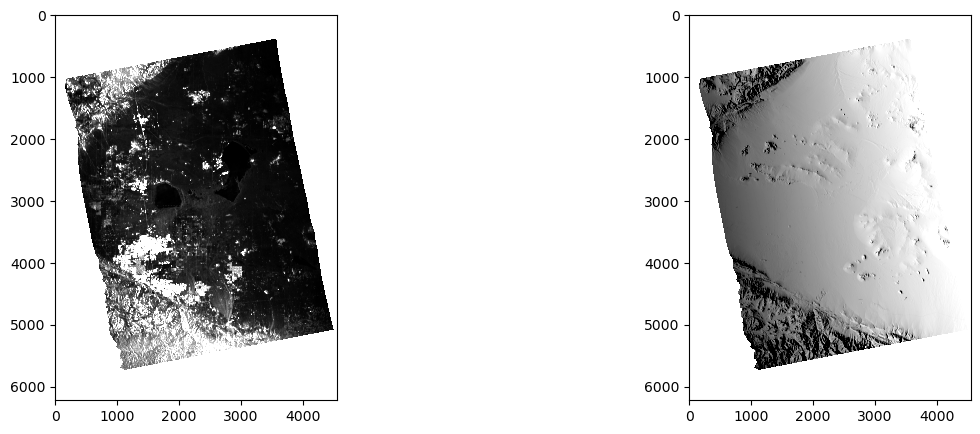

In [ ]:
GCOVbinary = nisarhdf.readVrtAsXarray('output/GCOVbinary.vrt', mask_and_scale=True)
#extent = [np.min(GCOVbinary.x), np.max(GCOVbinary.x), np.min(GCOVbinary.y), np.max(GCOVbinary.y)
# Get the band names
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for var, ax in zip(GCOVbinary.data_vars, axes.flatten()):
    vmin, vmax = nisarhdf.autoScaleRange(GCOVbinary[var].data, 95)
    ax.imshow(GCOVbinary[var].data, cmap='gray', vmin=vmin, vmax=vmax)
GCOVbinary

## Save Gridded Data Cubes

The gridded data cubes can also be saved as either flat binary or as cloud-optimized geotiff (COG) files. In this case, use `save=True` to save the result internally, and then use `writeData` to save data the same way the other bands are saved. In the example below, the data are saved as COGs.

In [16]:
myGCOV.incidenceAngleCube(myGCOV.xGrid, myGCOV.yGrid, z, maskNoData=myGCOV.noDataLocations, save=True);
myGCOV.elevationAngleCube(myGCOV.xGrid, myGCOV.yGrid, z, maskNoData=myGCOV.noDataLocations, save=True);
myGCOV.writeData('output/GCOVangles',bands=['incidenceAngle', 'elevationAngle'], tiff=True) # ', 'elevationAngle'

<xarray.Dataset> Size: 226MB
Dimensions:         (x: 4545, y: 6220)
Coordinates:
  * x               (x) float64 36kB 3.655e+05 3.655e+05 ... 4.564e+05 4.564e+05
  * y               (y) float64 50kB 3.914e+06 3.914e+06 ... 3.789e+06 3.789e+06
    spatial_ref     int64 8B 0
Data variables:
    incidenceAngle  (y, x) float32 113MB nan nan nan nan nan ... nan nan nan nan
    elevationAngle  (y, x) float32 113MB nan nan nan nan nan ... nan nan nan nan
Attributes: (12/19)
    bands:                    ['incidenceAngle', 'elevationAngle']
    ByteOrder:                LSB
    datetime:                 2008-10-12 06:09:11.567105
    epsg:                     32611
    frame:                    19
    LookDirection:            right
    ...                       ...
    SLCFirstZeroDopplerTime:  22151.567105
    SLCLastZeroDopplerTime:   22165.749341842104
    SLCNearRange:             743610.2093641666
    Wavelength:               0.2360571
    xSize:                    4545
    ySize:                    6220

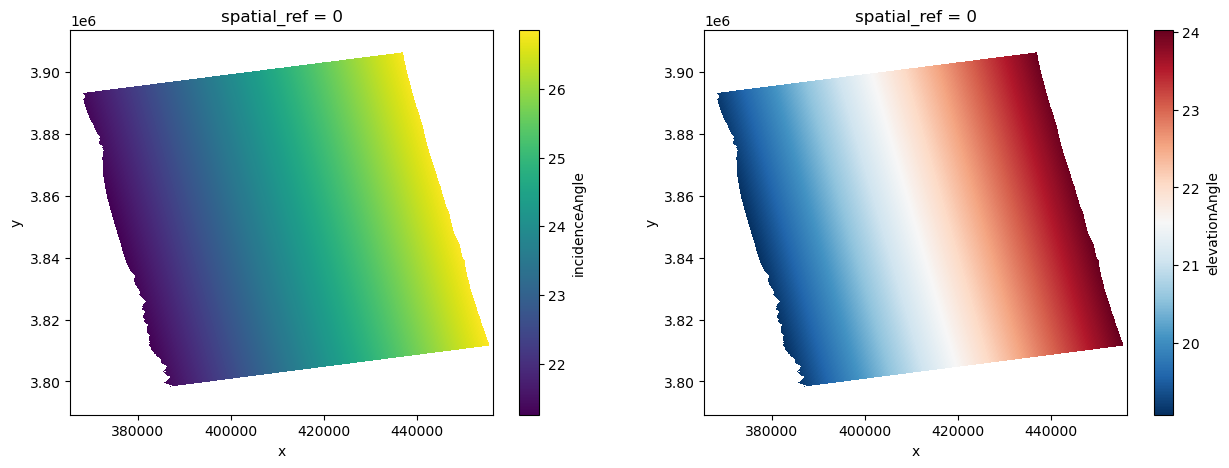

In [17]:
GCOVTiff = nisarhdf.readVrtAsXarray('output/GCOVangles.vrt', mask_and_scale=True)
#extent = [np.min(GCOVbinary.x), np.max(GCOVbinary.x), np.min(GCOVbinary.y), np.max(GCOVbinary.y)
# Get the band names
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
GCOVTiff.incidenceAngle.plot.imshow(ax=axes[0])
GCOVTiff.elevationAngle.plot.imshow(ax=axes[1], cmap='RdBu_r')
GCOVTiff

# Anything below here is debug code that can be ignored